# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2025

Druet, Yann, 2198643

Provost-Cardin, Alexandre, 2210084

Note finale: 

<u>**Date limite de remise :**</u>  11 Février 23h59 (Groupe B2), 18 Février 23h59 (Groupe B1)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer des nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuer sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaison). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- <u>**IMPORTANT**</u> Remettez le fichier du notebook sur Moodle avec le nom `MATRICULE1_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse théorique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.

## Description du problème

On vous demande de résoudre le problème classique de trier une liste de nombres aléatoires.

La taille de la liste `SIZE` ainsi que la grandeur maximale des nombres permis `MAX_NUMBER` changeront d'un échantillon à l'autre. Il est **important** de considérer les deux variables dans vos analyses. Par contre, si vous prouvez qu'une des variables n'affecte pas la complexité d'un algorithme, il n'est pas nécessaire de compléter le reste de l'analyse pour celle-ci.

Porter une attention particulière à vos analyses, car c'est ce qui est le plus important dans ce travail. Assurez vous de respecter un certain formalisme, comme si vous rédigiez un rapport, et de bien expliquez tous vos résultats et graphiques. Une réponse sans explication ne rapportera pas tous les points.

## Algorithmes à implanter

On vous demande de résoudre ce problème de 5 façons différentes :

1. En utilisant un algorithme simple: `Insertion Sort` ;
2. En utilisant un algorithme diviser pour régner: `Quick Sort` en utilisant un pivot simple ;
3. En utilisant l'algorithme précédent avec une certaine heuristique pour sélectionner le pivot ;
4. En utilisant l'algorithme précédent avec un seuil de récursivité non élémentaire ;
5. En utilisant un algorithme non comparatif: `Count Sort`.

Pour l'algorithme 2, nous considérons simple de sélectionner la valeur au centre de la liste comme le pivot. Pour l'algo 3, vous pourriez utiliser la médiane ou la pseudo médiane de l'ensemble de la liste ou d'un sous-ensemble comme étant le pivot, mais il y a d'autre possibilités.

Pour l’algorithme 4, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est inférieure à ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.


## Jeu de données

La classe `Problem` existe pour simplifier l'interface des différentes fonctions utilitaires. Elle permet de générer des jeux de données avec la méthode `generate_sample` ci-dessous. Elle génère une liste de taille `SIZE` contenant des nombres entre 1 et `MAX_NUMBER`. Vous pouvez utilisez des listes aléatoires pour tester votre code.

In [3]:
import random
from collections.abc import Iterable

class Problem():
    def __init__(self, size: int, max_number: int, num_samples: int = 5) -> None:
        self.size=size
        self.max_number=max_number
        self.num_samples=num_samples
        self.samples = self.generate_dataset()
    
    def generate_sample(self) -> list[int]:
        """Returns a list of the given size containing numbers between 1 and the max_number"""
        return [random.randint(1, self.max_number) for _ in range(self.size)]
    
    def generate_dataset(self) -> Iterable[list[int]]:
        """Returns an iterator over as many samples as are described """
        return (self.generate_sample() for _ in range(self.num_samples))

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leur performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [78]:
import matplotlib.pyplot as plt
import time
from collections.abc import Callable
from math import log10
from scipy.stats import linregress
import numpy

class InvalidSolution(Exception):
    def __init__(self):
        super().__init__("Invalid solution, verify your code.")

class Measure():
    """A wrapper to contain information on taken measures"""
    def __init__(self, size: int, max_number: int, mean: int) -> None:
        self.size = size
        self.max_number = max_number
        self.mean = mean

def convert_list_to_dict(original: list[int]) -> dict[int:int]:
    """Converts a list into a dictionary of frequencies"""
    freq: dict[int:int] = dict()
    for iter in original:
        if iter not in freq.keys():
            freq[iter] = 0
        freq[iter] += 1
    return freq

def is_valid_solution(original: list[int], solution: list[int]) -> bool:
    """Validates both if the solution is sorted and if the list was not modified"""
    # Lists must be of equal length
    if len(solution) != len(original):
        return False
    
    # List must be in increasing order
    for i in range(1, len(solution)):
        if solution[i-1] > solution[i]:
            return False
    
    original_freq = convert_list_to_dict(original)
    solution_freq = convert_list_to_dict(solution)
    # Lists must have the same values
    for key in original_freq.keys():
        if key not in solution_freq.keys() or\
            solution_freq[key] != original_freq[key]:
            return False
    
    # Solution is valid
    return True

def make_problems(sizes: list[int], max_numbers: list[int], num_samples: int = 5) -> list[Problem]:
    """Creates problem instances using given sizes and max_numbers"""
    problems: list[Problem] = []
    for size in sizes:
        for max_number in max_numbers:
            problems.append(Problem(size,max_number,num_samples))
    return problems

def measure(procedure: Callable[[list[int]],list[int]], sample: list[int], time_scale: int = 1000) -> int:
    """Returns the time in milliseconds taken to run the procedure.

    Raises:
        InvalidSolution: If the procedure returns an invalid solution, raises an exception.
    """
    start: int = time.time() * time_scale
    solution: list[int] = procedure(sample)
    end: int = time.time() * time_scale
    if not is_valid_solution(sample, solution):
        raise InvalidSolution()
    return round(end - start)

def measure_mean(procedure: Callable[[list[int]],list[int]], prob: Problem, time_scale: int = 1000) -> Measure:
    """Generates multiple samples with the specified parameters and returns the mean time in milliseconds

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    """
    mean_time = sum(
        [measure(procedure = procedure,sample = sample,time_scale = time_scale) for sample in prob.samples]
    ) / prob.num_samples
    return Measure(prob.size, prob.max_number, mean_time)

def measure_range(procedure: Callable[[list[int]],list[int]], problems: list[Problem], time_scale: int = 1000) -> list[Measure]:
    """Measures the mean time taken in milliseconds for each size in the given list.
    Uses a fixed max_number to measure the effect of size on its own.

    Raises:
        InvalidSolution: If one of the samples results in an invalid solution.
    
    Returns:
        A list of Measure instances containing the specifications
        of the problem as well as the mean time.
    """
    return [
        measure_mean(procedure, prob, time_scale)
        for prob in problems
    ]

def test_threshold(
    procedure: Callable[[list[int],int],list[int]],
    thresholds: list[int], problem: Problem
) -> dict[int,int]:
    """Tests the different thresholds on the same problem instance."""
    threshold_measures = dict()
    for threshold in thresholds:
        threshold_measures[threshold] = 0
        for sample in problem.generate_dataset():
            start = time.time() * 1000
            solution = procedure(sample,threshold)
            end = time.time() * 1000
            if not is_valid_solution(sample,solution):
                raise InvalidSolution()
            threshold_measures[threshold] += end - start
        threshold_measures[threshold] /= problem.num_samples
    return threshold_measures

def estimate_threshold(
    first_data: dict[int,int],
    second_data: dict[int,int],
    first_label: str,
    second_label: str
):
    plt.plot(list(first_data.keys()),list(first_data.values()),label=first_label)
    plt.plot(list(second_data.keys()),list(second_data.values()),label=second_label)
    plt.xlabel('Taille')
    plt.ylabel('Temps (ns)')
    plt.title('Estimation du seuil')
    plt.show()

def display_threshold_measures(data: dict[int,int]):
    """Displays a graph of the time take to solve in regards to the chosen threshold"""
    x = list(data.keys())
    y = list(data.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps (ms)')
    plt.title('Selection du seuil')
    plt.show()
     
def display_data_as_table(measures: list[Measure]):
    """Prints a table with the data in the given list of measures"""
    print("{: <12} {: <12} {: <12}".format("Taille", "Nombre maximal", "Temps moyen (ms)"))
    for measure in measures:
        print("{: <12} {: <12} {: <12}".format(measure.size, measure.max_number, measure.mean))

### The different tests are below, the names are in french to avoid confusion

def test_de_puissance(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de puissance"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    # Log both sets of values
    x = list(data.keys())
    y = list(data.values())
    
    log_x = numpy.log10(x)
    log_y = numpy.log10(y)
    # Perform the lin regression
    m, b, rvalue, _, _ = linregress(log_x, log_y)
    
    # Estimate the values of y based on the lin regression results
    predicted_log = m * log_x + b
    predicted = 10**predicted_log
    # Create the line equation
    equation = f"$y = {10**b:.2f} \\cdot x^{{{m:.2f}}}$"


    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire ($R²={rvalue**2:.3f}$)')
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xscale("log")
    plt.yscale("log")

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), equation)

    # Show the plot
    plt.show()

def test_de_rapport(
    data: dict[int,int],
    x_label: str,
    y_label: str,
    title: str = "Test de rapport"
):
    """Takes the data and displays it into the corresponding test graph.
    It applies no transformations to the data.
ired positional aro transformations to the data.

    Args:
        data (dict[int,int]): A dictionnary mapping the x variable to the y variable
    """
    x = list(data.keys())
    y = list(data.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    predicted = [m * iter + b for iter in x]

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, predicted, color="red", label=f'Regression linéaire R²={round(rvalue**2,6)}')

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

## Exemple : Bubble Sort

In [8]:
def bubble_sort(original: list[int]) -> list[int]:
    for i in range(len(original)):
        for j in range(0, len(original)-i-1):
            if original[j] > original[j+1]:
                original[j], original[j+1] = original[j+1], original[j]
    return original

# This test would allow to see the variation associated to the SIZE variable
measures = measure_range(bubble_sort, make_problems([1000,1500,2000],[4000]))
display_data_as_table(measures)

# This test would allow to see the variation associated to the MAX_NUMBER variable. Results show that there is no variation
measures = measure_range(bubble_sort, make_problems([2000],[2000,3000,4000]))
display_data_as_table(measures)

Taille       Nombre maximal Temps moyen (ms)
1000         4000         36.8        
1500         4000         85.4        
2000         4000         156.6       
Taille       Nombre maximal Temps moyen (ms)
2000         2000         178.6       
2000         3000         183.2       
2000         4000         185.2       


## Partie 1 : Algorithme simple (Insertion Sort) (5 pts)

<u>**Question 1.a):**</u> Implantez l'algorithme de tri insertion sort.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [32]:
def insertion_sort(original: list[int]) -> list[int]:
    i = 1
    while i < len(original):
        j = i
        while j > 0 and original[j-1] > original[j]:
            temp = original[j]
            original[j] = original[j-1]
            original[j-1] = temp
            j = j - 1
        i = i + 1
    return original

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez
Meilleur cas: O(n)
Pire cas: O(n^2)
Cas moyen: O(n^2)

Dans le meilleur cas, la liste est déjà triée. On doit parcourir tous les éléments une fois pour les comparer (n éléments).
Dans le pire cas, la liste est triée dans l'ordre inverse. Chaque élément doit être comparé et échangé avec chaque autre élément (n éléments * n éléments) donc n^2.
Dans le cas moyen, la liste est partiellement aléatoire. Chaque élément devra être comparé avec une partie quelconque des autres éléments. La complexité reste quadratique. Ex. (n éléments * n éléments/2)

### Mesures

Pour cet algorithme ainsi que les prochains, vous devez choisir les différentes tailles de liste que vous voulez tester. Choisissez des tailles qui ont des résultats intéressants, une taille de 5 qui se termine en une fraction de millisecondes n'est pas le meilleur résultat pour faire des comparaisons.

Pour faire des mesures, utilisez la fonction `measure_range`. Elle permet de faire des mesures sur une liste de problèmes. Vous pouvez facilement créer des problèmes en utilisant la fonction `make_problems`. Ne faites varier que la taille <u>**OU**</u> la grandeur maximale des nombres pour observer le comportement d'un des deux paramètres. Le code fournit s'occupera de générer des échantillons aléatoires, de calculer le temps moyen et de vous retourner une liste de mesures. Vous pouvez utilisez la fonction `range` de python pour obtenir une grande liste et avoir plusieurs points (faites attention au temps d'exécution).

Ces données peuvent ensuite être passées aux fonctions `test_de_...` en les mettant dans un `dict` python tel que `x:y`. Les tests ont de la documentation pour expliquer leur utilisation en plus de détails.

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [33]:
# TODO take measurements
measures_insertion_sort = measure_range(insertion_sort, make_problems(range(500, 1500, 10),[10000]))


In [35]:
# TODO Display data as tables
display_data_as_table(measures_insertion_sort)


Taille       Nombre maximal Temps moyen (ms)
500          10000        9.8         
510          10000        7.0         
520          10000        7.4         
530          10000        7.8         
540          10000        8.2         
550          10000        8.0         
560          10000        9.0         
570          10000        9.0         
580          10000        9.2         
590          10000        10.0        
600          10000        10.2        
610          10000        11.0        
620          10000        11.2        
630          10000        11.8        
640          10000        12.2        
650          10000        12.2        
660          10000        13.0        
670          10000        13.4        
680          10000        13.8        
690          10000        14.6        
700          10000        14.6        
710          10000        15.0        
720          10000        15.4        
730          10000        16.0        
740          10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

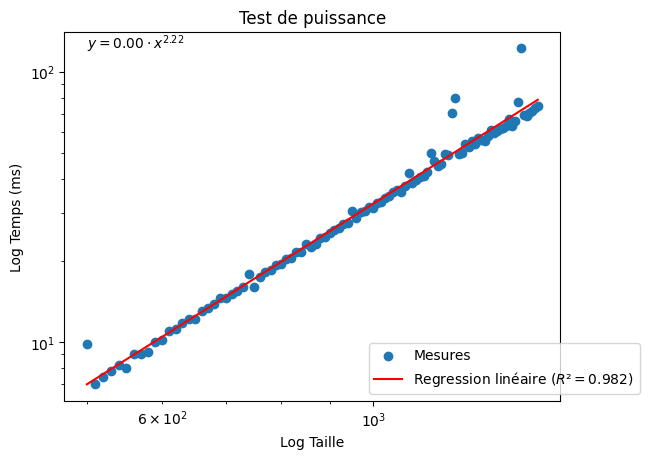

In [38]:
# TODO Test de puissance
mesure_insertion_sort_dict: dict[int: int] = {}
for m in measures_insertion_sort:
    mesure_insertion_sort_dict[m.size] = m.mean

test_de_puissance(mesure_insertion_sort_dict, "Log Taille", "Log Temps (ms)")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Sur le graphique, on peut voir que les mesures suivent une tendance linéaire dans l'échelle log-log, ce qui correspond à un taux de croissance en temps polynomial. La régression linéaire estime une complexité de O(n^2.22), ce qui est assez proche de la complexité attendue du tri par insertion (O(n^2)). La variation pourrait être expliquée par notre implémentation ou les données que nous avons utilisé. 

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

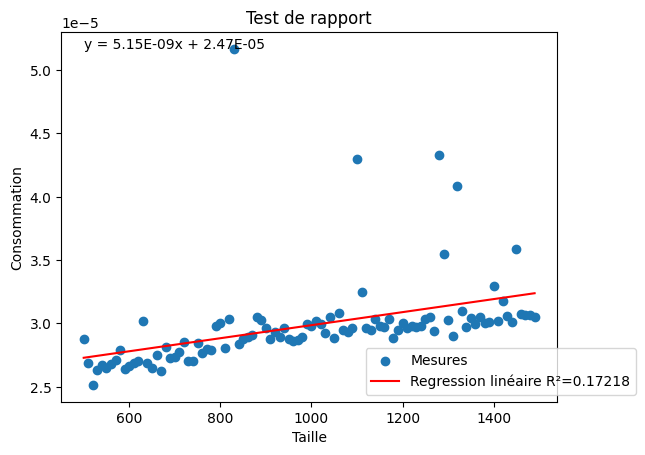

In [320]:
# TODO Test de rapport
mesure_insertion_sort_dict: dict[int: int] = {}
for m in measures_insertion_sort:
    mesure_insertion_sort_dict[m.size] = m.mean / (m.size * m.size) # f(x) = x^2 pour insertion sort
test_de_rapport(mesure_insertion_sort_dict, "Taille", "Consommation")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Dans le graphique, à part certaines valeurs aberrantes, il semble y avoir convergence vers une valeur, qui est environ 3.0e-5. Cela voudrait dire que la consommation en temps de notre algorithme est donnée par 3.0e-5 * n^2 (y = b * f(x)). 

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

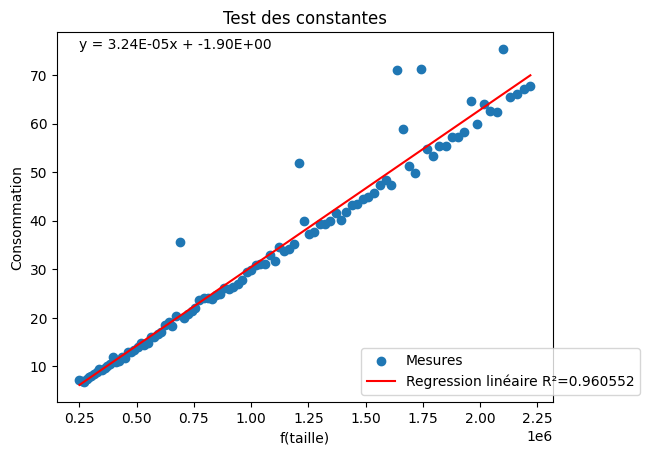

In [381]:
# TODO Test des constantes
mesure_insertion_sort_dict: dict[int: int] = {}
for m in measures_insertion_sort:
    mesure_insertion_sort_dict[m.size*m.size] = m.mean
test_de_rapport(mesure_insertion_sort_dict, "f(taille)", "Consommation", "Test des constantes")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Dans le graphique, nous pouvons voir que les données suivent assez près une tendance linéaire donnée par l'équation y = 3.24e-5 * x - 1.90 (y = c * f(x) + b). La valeur de c trouvée ici est similaire à celle trouvée lors du test du rapport, ce qui semble confirmer que la consommation en temps de notre algorithme est donnée par y = c * f(x) où c = 3.24e-5 et f(x) = x^2.

## Partie 2 : Algorithme diviser pour régner (Quick Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri quick sort avec un pivot simple.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [25]:
def partition_array(array: list[int], left: int, right: int) -> int:
    pivot = array[right]
    i = left - 1

    for j in range(left, right):
        if array[j] <= pivot:
            i += 1
            array[i], array[j] = array[j], array[i]
    array[i + 1], array[right] = array[right], array[i + 1]

    return i + 1

def quick_sort_call(array: list[int], low: int, high: int): 
    if low < high:
        pivot = partition_array(array, low, high)
        quick_sort_call(array, low, pivot - 1)
        quick_sort_call(array, pivot + 1, high)
    
def quick_sort(original: list[int]) -> list[int]:
    low = 0
    high = len(original) - 1

    quick_sort_call(original, low, high)

    return original

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

Cas moyen: O(n log n)
Meilleur cas: O(n log n)
Pire cas: O(n^2)

Si le pivot est bien choisi, alors chaque partition divise le tableau en deux parties de taille approximativement égale. On crée un arbre de récursion de profondeur log n, car on divise la taille des données par 2 à chaque niveau. Chaque partition doit être parcourue et partitionnée une fois (n éléments). Le coût total est donc n * log n. Par contre, si le pivot est toujours mal choisi, alors chaque partition est déséquilibrée et on enlève seulement un élément à chaque fois qu'on partitionne. On doit donc partitionner n fois et parcourir les éléments de chaque partition (n éléments). Le coût total est donc n * n.

### Mesures

<u>**Question 1.c):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [93]:
# TODO take measurements
measures_quick_sort = measure_range(quick_sort, make_problems(range(10000, 50000, 500),[10000]))


In [27]:
display_data_as_table(measures_quick_sort)

Taille       Nombre maximal Temps moyen (ms)
10000        10000        11.6        
10500        10000        13.2        
11000        10000        13.2        
11500        10000        13.8        
12000        10000        14.2        
12500        10000        14.6        
13000        10000        15.4        
13500        10000        16.2        
14000        10000        16.4        
14500        10000        17.6        
15000        10000        18.6        
15500        10000        20.2        
16000        10000        19.4        
16500        10000        20.4        
17000        10000        22.2        
17500        10000        21.8        
18000        10000        23.0        
18500        10000        23.6        
19000        10000        24.4        
19500        10000        25.0        
20000        10000        25.6        
20500        10000        26.4        
21000        10000        27.6        
21500        10000        28.8        
22000        10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

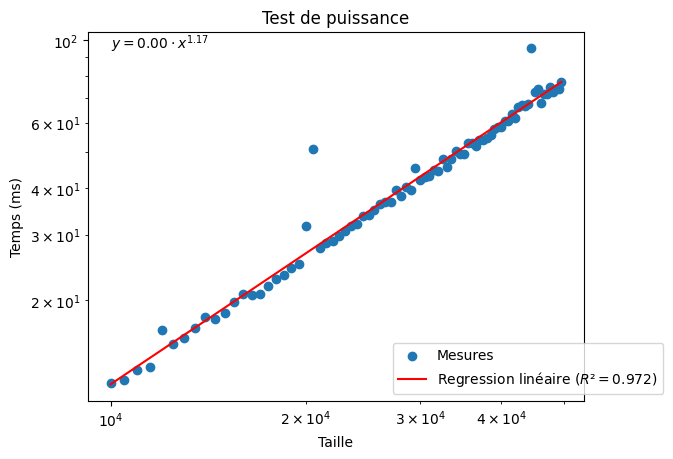

In [95]:
# TODO Test de puissance
mesure_quick_sort_dict: dict[int: int] = {}
for m in measures_quick_sort:
    mesure_quick_sort_dict[m.size] = m.mean

test_de_puissance(mesure_quick_sort_dict, "Taille", "Temps (ms)")


<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Sur le graphique, on peut voir que les mesures suivent une tendance linéaire dans l'échelle log-log, ce qui correspond à un taux de croissance en temps polynomial. La régression linéaire estime une complexité de O(n^1.17), ce qui est proche de la complexité attendue du quicksort en cas moyen, soit O(n log ⁡n). En effet, en comparant des valeurs, nous pouvons affirmer que n log n et n^1.17 ont un taux de croissance similaire. 

n = 10: 

10 * log(10) = 10

10^1.17 = 14.79

n = 100:

100 * log(100) = 200

100^1.17 = 218.78

n = 1000:

1000* log(1000) = 3000

1000^1.17 = 3235.94

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

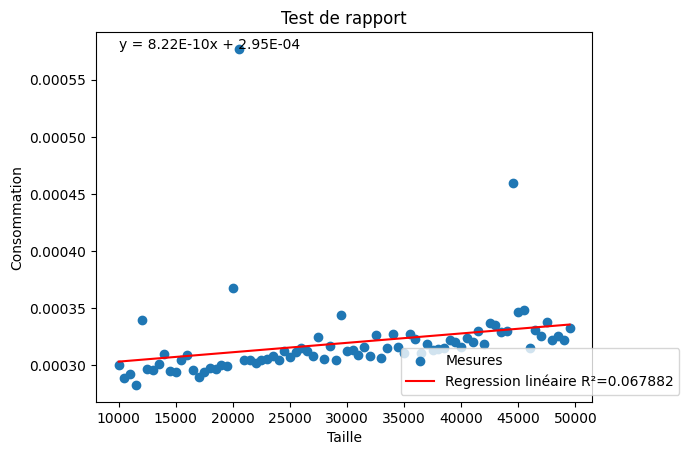

In [94]:
# TODO Test de rapport
mesure_quick_sort_dict: dict[int: int] = {}
for m in measures_quick_sort:
    mesure_quick_sort_dict[m.size] = m.mean / (m.size * log10(m.size)) # f(x) = xlogx pour quick sort
test_de_rapport(mesure_quick_sort_dict, "Taille", "Consommation")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Dans le graphique, à part certaines valeurs aberrantes, il semble y avoir convergence vers une valeur située entre 0.00030 et 0.00035.
Cela voudrait dire que la consommation en temps de notre algorithme est donnée par environ 0.000325 * (log n * n) (y = b * f(x)). 

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

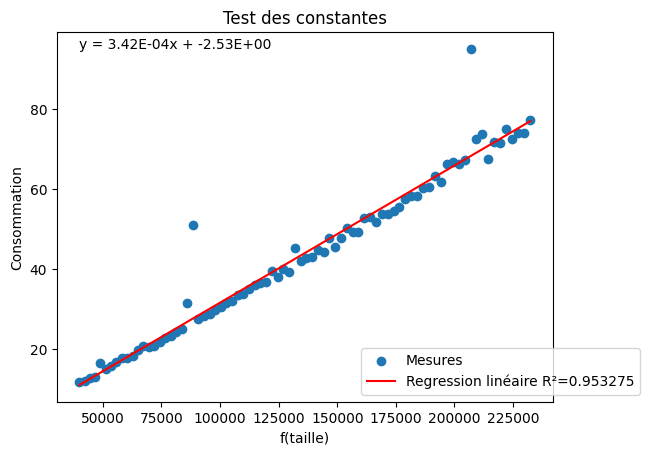

In [96]:
# TODO Test des constantes-
mesure_quick_sort_dict: dict[int: int] = {}
for m in measures_quick_sort:
    mesure_quick_sort_dict[m.size*log10(m.size)] = m.mean # f(x) = xlogx pour quick sort
test_de_rapport(mesure_quick_sort_dict, "f(taille)", "Consommation", "Test des constantes")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Dans le graphique, nous pouvons voir que les données suivent assez près une tendance linéaire donnée par l'équation y = 3.42e-4 * x - 2.53 (y = c * f(x) + b). La valeur de c trouvée ici est similaire à celle trouvée lors du test du rapport, ce qui semble confirmer que la consommation en temps de notre algorithme est donnée par y = c * f(x) où c = 3.42e-4 et f(x) = x log x.

## Partie 3 : Algorithme diviser pour régner amélioré (Quick Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri quick sort, avec une certaine heuristique pour sélectionner un pivot pertinent.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [109]:
def quick_sort_improved(original: list[int]) -> list[int]:
    low = 0
    high = len(original) - 1

    quick_sort_call_improved(original, low, high)
    return original

def medianOf3(array: list[int], left: int, right: int) -> int:
    mid = (left + right) // 2
    a, b, c = array[left], array[mid], array[right]

    if a < b:
        if b < c:
            median_idx = mid
        else:
            if a < c:
                median_idx = right
            else:
                median_idx = left
    else:
        if a < c:
            median_idx = left
        else:
            if b < c:
                median_idx = right
            else:
                median_idx = mid
                
    array[median_idx], array[right] = array[right], array[median_idx]
    return partition_array_improved(array, left, right)

def partition_array_improved(array: list[int], left: int, right: int) -> int:
    pivot = array[right]
    i = left - 1

    for j in range(left, right):
        if array[j] <= pivot:
            i += 1
            array[i], array[j] = array[j], array[i]
    array[i + 1], array[right] = array[right], array[i + 1]

    return i + 1


def quick_sort_call_improved(array: list[int], low: int, high: int): 
    if low < high: 
        pivot = medianOf3(array, low, high)
        quick_sort_call_improved(array, low, pivot - 1)
        quick_sort_call_improved(array, pivot + 1, high)

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

Cas moyen: O(n log n)
Meilleur cas: O(n log n)
Pire cas: O(n^2)

Notre heuristique a pour but de trouver un meilleur pivot. Nous avons expliqué plus tôt qu'avec un bon pivot (meilleur cas), la complexité de l'algorithme quicksort reste toujours O(n log n), car nous devons créer environ log n niveaux de récursion, et chaque niveau doit être complètement parcouru (n éléments). Si notre heuristique n'arrive pas à trouver un bon pivot (pire cas), par exemple, à cause de données avec beaucoup d'éléments identiques, il est possible que nos partitions soient déséquilibrées et donc que la complexité soit O(n^2) comme pour le quicksort sans heuristique.

<u>**Question 1.c):**</u> Quelle est l'impact de l'ajout de votre heuristique? Expliquez

Notre heuristique a pour but de réduire la probabilité d'avoir des partitionnements déséquilibrés (pire cas), ce qui nous permet d'améliorer la performance du quicksort en obtenant une complexité plus proche de O(n log n) dans la majorité des cas.

### Mesures

<u>**Question 1.d):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [221]:
# TODO take measurements
measures_quick_sort_improved = measure_range(quick_sort_improved, make_problems(range(10000, 50000, 500),[10000]))

In [169]:
# TODO Display data as tables
display_data_as_table(measures_quick_sort_improved)

Taille       Nombre maximal Temps moyen (ms)
10000        10000        12.6        
10500        10000        15.2        
11000        10000        13.4        
11500        10000        14.2        
12000        10000        15.4        
12500        10000        15.8        
13000        10000        16.6        
13500        10000        16.4        
14000        10000        17.6        
14500        10000        17.8        
15000        10000        18.6        
15500        10000        19.2        
16000        10000        20.4        
16500        10000        21.4        
17000        10000        21.4        
17500        10000        22.4        
18000        10000        22.6        
18500        10000        26.4        
19000        10000        24.8        
19500        10000        25.8        
20000        10000        29.0        
20500        10000        33.0        
21000        10000        27.8        
21500        10000        29.6        
22000        10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

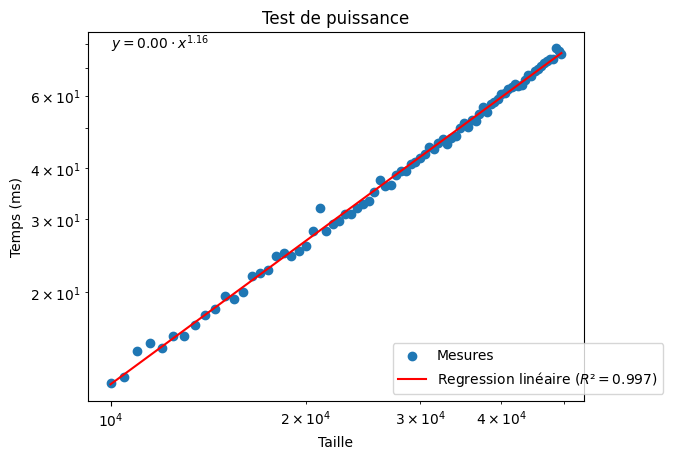

In [222]:
# TODO Test de puissance
measures_quick_sort_improved_dict: dict[int: int] = {}
for m in measures_quick_sort_improved:
    measures_quick_sort_improved_dict[m.size] = m.mean

test_de_puissance(measures_quick_sort_improved_dict, "Taille", "Temps (ms)")



<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Sur le graphique, on peut voir que les mesures suivent une tendance linéaire dans l'échelle log-log, ce qui correspond à un taux de croissance en temps polynomial. La régression linéaire estime une complexité de O(n^1.16), ce qui se rapproche encore plus de la complexité attendue du quicksort en cas moyen, soit O(n log ⁡n). 

n = 10: 

10 * log(10) = 10

10^1.16 = 14.45

n = 100:

100 * log(100) = 200

100^1.16 = 208.93

n = 1000:

1000* log(1000) = 3000

1000^1.16 = 3019.95

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

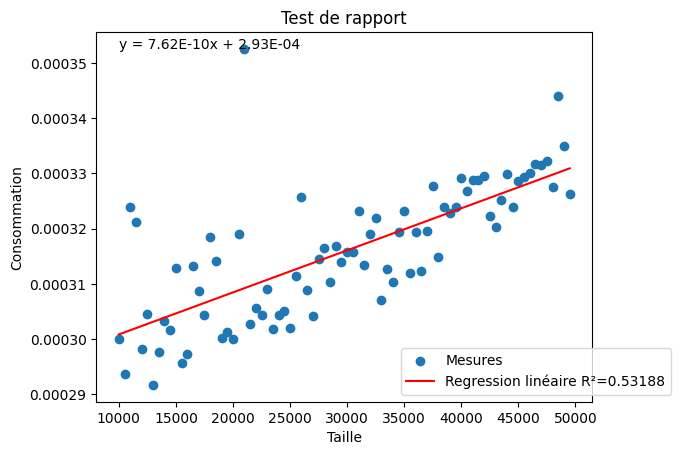

In [223]:
# TODO Test de rapport
mesure_quick_sort_improved_dict: dict[int: int] = {}
for m in measures_quick_sort_improved:
    mesure_quick_sort_improved_dict[m.size] = m.mean / (m.size * log10(m.size)) # f(x) = xlogx pour quick sort
test_de_rapport(mesure_quick_sort_improved_dict, "Taille", "Consommation")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Comme pour le quicksort original, il semble y avoir convergence vers une valeur située entre 0.00030 et 0.00035. Les données semblent un peu plus dispersées que le quicksort original, mais en réalité ne le sont pas, car l'axe des y contient des valeurs entre 0.00029 et 0.00035 comparativement au graphique original qui contient des valeurs entre 0.00025 et 0.00060. Avec la version améliorée du quicksort, nous remarquons moins de données aberrantes (pire cas), ce qui était son but.
La consommation en temps de notre algorithme est encore donnée par environ 0.000325 * (log n * n) (y = b * f(x)). 

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

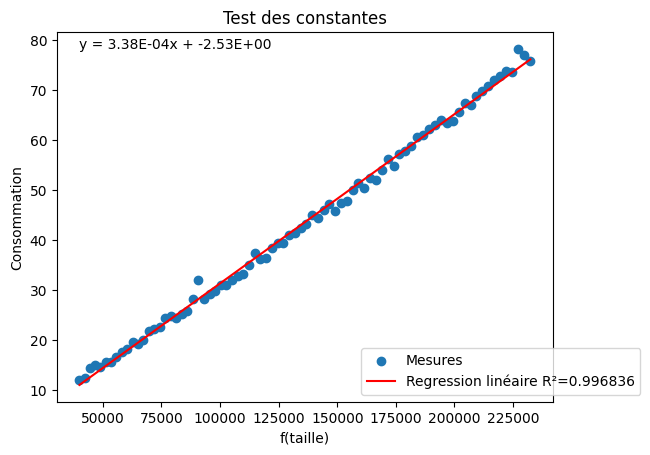

In [224]:
# TODO Test des constantes
mesure_quick_sort_improved_dict: dict[int: int] = {}
for m in measures_quick_sort_improved:
    mesure_quick_sort_improved_dict[m.size*log10(m.size)] = m.mean # f(x) = xlogx pour quick sort
test_de_rapport(mesure_quick_sort_improved_dict, "f(taille)", "Consommation", "Test des constantes")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Dans le graphique, nous pouvons voir que les données suivent assez près une tendance linéaire donnée par l'équation y = 3.38^-4 * x - 2.53 (y = c * f(x) + b). La valeur de c trouvée ici est encore similaire à celle trouvée lors du test du rapport, ce qui semble confirmer que la consommation en temps de notre algorithme est donnée par y = c * f(x) où c = 3.38^-4 et f(x) = x log x.

## Partie 4 : Algorithme diviser pour régner avec seuil arbitraire (Quick Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Quel serait un meilleur choix de seuil? Utilisez la fonction `estimate_threshold` pour avoir une idée où commencer. Analysez le graphe résultant et choisissez un seuil de départ.

On recommande de compiler des nouvelles données sur des tailles plus petites. Utilisez un `time_scale` plus grand pour avoir plus de détails (indiquez les unités dans le `y_label`). Une fois que vous avez une idée d'où se situe le point de croisement, vous pouvez refaire le test sur une sélection plus restreinte de tailles en augmentant `num_samples` pour avoir des résultats plus constants.

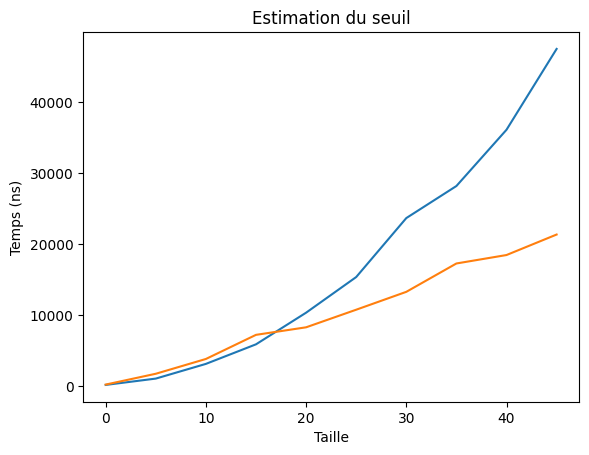

In [307]:
# TODO Find a better starting point for the threshold
sizes = list(range(0, 50, 5))
max_numbers = [1000]
num_samples = 1000
time_scale = 1e9

insertion_sort_measures = measure_range(insertion_sort, make_problems(sizes, max_numbers, num_samples), time_scale)
quick_sort_improved_measures = measure_range(quick_sort_improved, make_problems(sizes, max_numbers, num_samples), time_scale)

insertion_sort_data = {m.size: m.mean for m in insertion_sort_measures}
quick_sort_improved_data = {m.size: m.mean for m in quick_sort_improved_measures}

estimate_threshold(insertion_sort_data, quick_sort_improved_data, 'Insertion sort', 'Improved quick sort')

<u>**Question 1.b):**</u> Reprenez l'algorithme précédent et modifiez-le pour y ajouter un seuil de récursivité. En dessous de ce seuil, vous utiliserez l'algorithme `insertion_sort` écrit précédemment.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [226]:
def quick_sort_threshold(original: list[int], threshold: int = 20) -> list[int]:
    low = 0
    high = len(original) - 1

    quick_sort_call_threshold(original, low, high, threshold)
    return original

def medianOf3(array: list[int], left: int, right: int) -> int:
    mid = (left + right) // 2
    a, b, c = array[left], array[mid], array[right]

    if a < b:
        if b < c:
            median_idx = mid
        else:
            if a < c:
                median_idx = right
            else:
                median_idx = left
    else:
        if a < c:
            median_idx = left
        else:
            if b < c:
                median_idx = right
            else:
                median_idx = mid
                
    array[median_idx], array[right] = array[right], array[median_idx]
    return partition_array_improved(array, left, right)

def partition_array_improved(array: list[int], left: int, right: int) -> int:
    pivot = array[right]
    i = left - 1

    for j in range(left, right):
        if array[j] <= pivot:
            i += 1
            array[i], array[j] = array[j], array[i]
    array[i + 1], array[right] = array[right], array[i + 1]

    return i + 1

def quick_sort_call_threshold(array: list[int], low: int, high: int, threshold: int): 
    if len(array) < threshold:
        insertion_sort(array)
    elif low < high: 
        pivot = medianOf3(array, low, high)
        quick_sort_call_threshold(array, low, pivot - 1, threshold)
        quick_sort_call_threshold(array, pivot + 1, high, threshold)


<u>**Question 1.c):**</u> À l'aide de ce que vous avez vu dans la section précédente, effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux. Affichez les dans un graphique une fois que les mesures sont compilées. La fonction `test_threshold` vous sera utile pour faire ces tests. Choisissez bien vos seuils ainsi qu'une taille de liste permettant de bien observer la différence de performance.

In [318]:
# TODO Test different threshold values
measures_quick_sort_threshold = test_threshold(quick_sort_threshold,range(0, 200, 5), Problem(10000, 10000, 100))

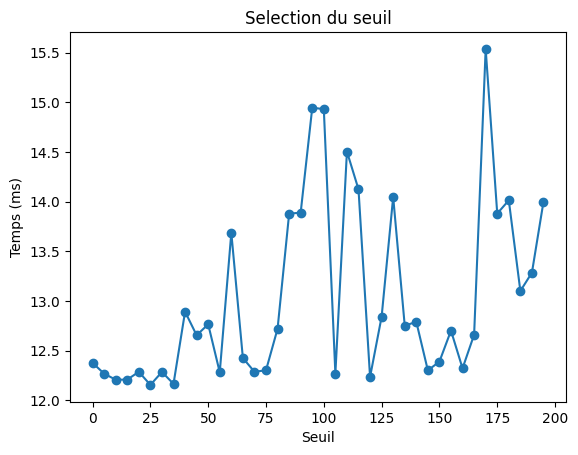

In [319]:
# TODO Display a graph with the measurements
display_threshold_measures(measures_quick_sort_threshold)


<u>**Question 1.d):**</u> Quel est le seuil de récursivité le plus judicieux? Sur quel critère l'avez vous sélectionné? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances?

Changez le seuil par défaut de votre fonction au meilleur choix. Ceci vous permettra d'utiliser les fonctions utilitaires sans passer le seuil comme argument.

Selon le graphique ci-haut, les meilleures valeurs de seuil se situent environ entre 15 et 30. Ce sont ces valeurs qui semblent minimiser le temps d'exécution le plus possible. Certaines valeurs plus élevées semblent donner des temps d'exécution faibles aussi, mais à plus haute valeur, il semble que le temps d'exécution est plus imprévisible. Les seuils inférieurs causent une sous-utilisation de l'insertion sort; quicksort continue à diviser en petites partitions, qui sont un peu plus inefficaces pour celui-ci. Les seuils supérieurs causent une surutilisation de l'insertion sort. Puisque l'insertion sort a une complexité O(n^2) en cas moyen, les partitions trop grandes sont beaucoup plus lentes à trier pour celui-ci. Nous avons donc choisi un seuil de 20.

<u>**Question 1.e):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

Cas moyen: O(n log n)
Meilleur cas: O(n log n)
Pire cas: O(n^2)

La complexité de notre algorithme quicksort avec seuil reste similaire au quicksort original. Puisque l'insertion sort est seulement utilisé sur des petites partitions, sa complexité a un impact négligeable sur la complexité totale de l'algorithme.

### Mesures

<u>**Question 1.f):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`.

In [373]:
# TODO take measurements
measures_quick_sort_threshold = measure_range(quick_sort_threshold, make_problems(range(10000, 50000, 500),[10000]))

In [359]:
# TODO Display data as tables
display_data_as_table(measures_quick_sort_threshold)

Taille       Nombre maximal Temps moyen (ms)
10000        10000        13.4        
10500        10000        12.8        
11000        10000        13.4        
11500        10000        14.4        
12000        10000        14.8        
12500        10000        16.2        
13000        10000        16.4        
13500        10000        17.4        
14000        10000        18.2        
14500        10000        19.0        
15000        10000        19.2        
15500        10000        20.4        
16000        10000        21.0        
16500        10000        21.6        
17000        10000        22.4        
17500        10000        23.0        
18000        10000        24.4        
18500        10000        25.0        
19000        10000        26.0        
19500        10000        27.0        
20000        10000        27.2        
20500        10000        28.0        
21000        10000        28.6        
21500        10000        29.6        
22000        10000 

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

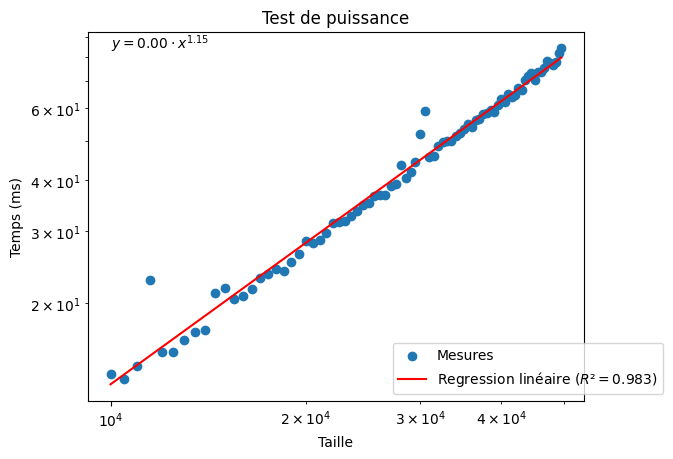

In [374]:
# TODO Test de puissance
measures_quick_sort_threshold_dict: dict[int: int] = {}
for m in measures_quick_sort_threshold:
    measures_quick_sort_threshold_dict[m.size] = m.mean

test_de_puissance(measures_quick_sort_threshold_dict, "Taille", "Temps (ms)")

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Sur le graphique, on peut voir que les mesures suivent une tendance linéaire dans l'échelle log-log, ce qui correspond à un taux de croissance en temps polynomial. La régression linéaire estime une complexité de O(n^1.15), donc semble grandir plus lentement que le cas moyen du quicksort original O(n log n)

n = 10: 

10 * log(10) = 10

10^1.15 = 14.13

n = 100:

100 * log(100) = 200

100^1.15 = 199.53

n = 1000:

1000* log(1000) = 3000

1000^1.15 = 2818.38

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

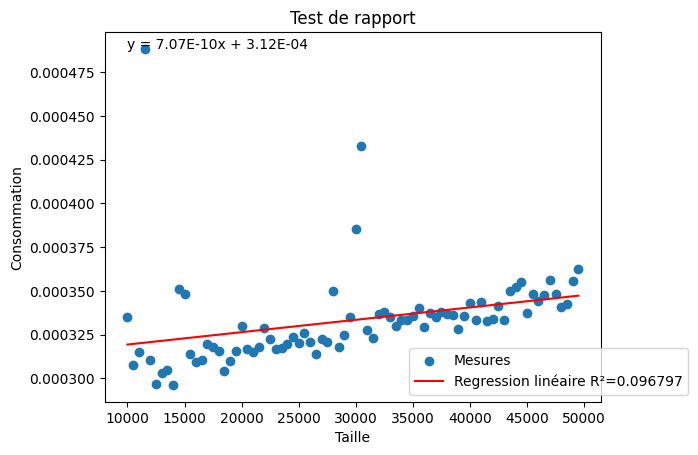

In [376]:
# TODO Test de rapport
measures_quick_sort_threshold_dict: dict[int: int] = {}
for m in measures_quick_sort_threshold:
    measures_quick_sort_threshold_dict[m.size] = m.mean / (m.size * log10(m.size)) # f(x) = xlogx pour quick sort
test_de_rapport(measures_quick_sort_threshold_dict, "Taille", "Consommation")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Similaire aux deux autres versions du quicksort, il semble y avoir convergence vers une valeur située entre 0.00030 et 0.00035.
La consommation en temps de notre algorithme est encore donnée par environ 0.000325 * (log n * n) (y = b * f(x)). 

#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

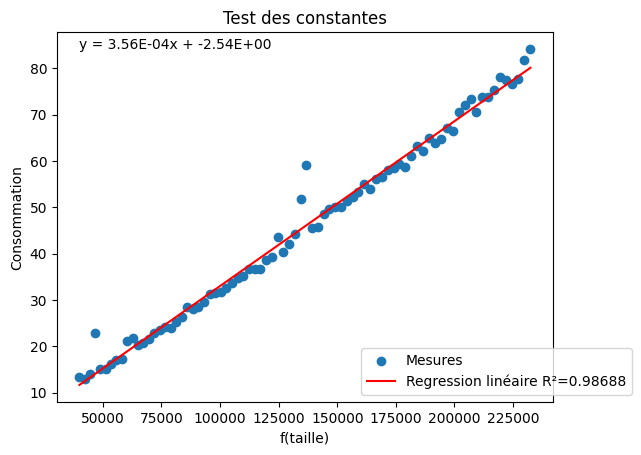

In [377]:
# TODO Test des constantes
measures_quick_sort_threshold_dict: dict[int: int] = {}
for m in measures_quick_sort_threshold:
    measures_quick_sort_threshold_dict[m.size*log10(m.size)] = m.mean # f(x) = xlogx pour quick sort
test_de_rapport(measures_quick_sort_threshold_dict, "f(taille)", "Consommation", "Test des constantes")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.


Dans le graphique, nous pouvons voir que les données suivent assez près une tendance linéaire donnée par l'équation y = 3.56e-4 * x - 2.54 (y = c * f(x) + b). La consommation en temps de notre algorithme est donnée par y = c * f(x) où c = 3.56e-4 et f(x) = x log x.

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente-t-il pour l'algorithme diviser pour régner et l'algorithme naïf ?

Le seuil de récursivité semble avoir eu un petit impact sur la performance de notre algorithme. Selon le test de puissance effectué, sa consommation en temps croit à une vitesse un peu moins élevée que celle du quicksort original. Pour l'algorithme quicksort, le seuil représente la taille où on cesse la récursion et on applique le tri plus simple pour optimiser la performance. Pour l'algorithme insertion sort, le seuil détermine la taille maximale des tableaux qu'il peut traiter efficacement avant que le coût quadratique soit trop important.

## Partie 5 : Algorithme non comparatif (Count Sort) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez l'algorithme de tri count sort. Cet algorithme ne fait pas de comparaison entre les différents éléments de la liste.

Utilisez la fonction `is_valid_solution` pour valider votre réponse sur quelques exemplaires aléatoires.

In [388]:
def count_sort(original: list[int]) -> list[int]:
    if not original:
        return original

    M = max(original)

    count_array = [0] * (M + 1)

    for num in original:
        count_array[num] += 1

    sorted_array = []
    for num, count in enumerate(count_array):
        sorted_array.extend([num] * count)

    return sorted_array


<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme? Expliquez

La complexité de l'algorithme est O (N + M) où N est le nombre d'éléments dans original et M le plus grand nombre présent dans l'algorithme, car on crée un array avec la même longeur que le plus grand nombre présent dans la liste originale

<u>**Question 1.c):**</u> Quel sera l'effet de cette complexité comparativement aux algorithmes précédents.

La complexité de cet algorithme devrait être meilleure que celle dans les algorithmes précédents, car O(n*log(n)) est plus grand que O(Max(n,m)) sauf lorsque la valeur de M est plus grande que n*log(n) dans un cas où le nombre d'éléments dans la liste est petit en comparaison avec la plus grande valeur de de la liste.


### Mesures

<u>**Question 1.d):**</u> Faites afficher vos mesures dans un tableau avec la fonction `display_data_as_table`. Étant donné les particularités de cet algorithme, il serait plus pertinent de tester des problèmes où max number ≤ size.

In [420]:
measures_count_sort = measure_range(count_sort, make_problems(range(10000, 500000, 10000),[1000]))

In [421]:
# TODO Display data as tables
display_data_as_table(measures_count_sort)

Taille       Nombre maximal Temps moyen (ms)
10000        1000         1.0         
20000        1000         1.0         
30000        1000         2.0         
40000        1000         2.0         
50000        1000         3.0         
60000        1000         3.0         
70000        1000         4.2         
80000        1000         4.4         
90000        1000         5.0         
100000       1000         5.6         
110000       1000         6.2         
120000       1000         6.6         
130000       1000         7.0         
140000       1000         8.0         
150000       1000         9.0         
160000       1000         11.0        
170000       1000         10.0        
180000       1000         10.6        
190000       1000         11.2        
200000       1000         12.0        
210000       1000         14.0        
220000       1000         13.2        
230000       1000         14.0        
240000       1000         15.6        
250000       1000  

### Analyse Hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

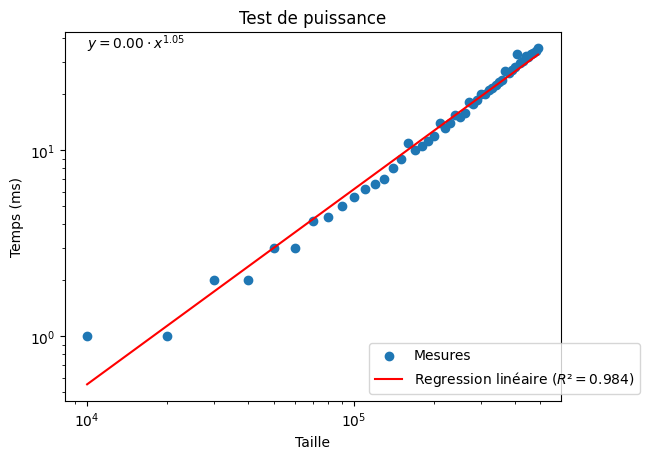

In [422]:
# TODO Test de puissance
measures_count_sort_dict: dict[int: int] = {}
for m in measures_count_sort:
    measures_count_sort_dict[m.size] = m.mean

test_de_puissance(measures_count_sort_dict, "Taille", "Temps (ms)")

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.


Sur le graphique, on peut voir que les mesures suivent une tendance linéaire dans l'échelle log-log, ce qui correspond à un taux de croissance en temps polynomial. La régression linéaire estime une complexité de O(n^1.05), ce qui, comme attendu, est considérablement plus faible que les autres algorithmes.

#### Test de rapport

<u>**Question 3.a):**</u> Effectuez le test de rapport de votre algorithme.

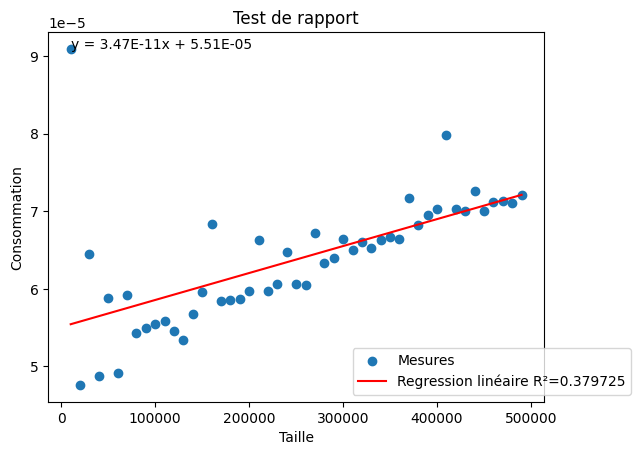

In [426]:
# TODO Test de rapport
measures_count_sort_dict: dict[int: int] = {}
for m in measures_count_sort:
    measures_count_sort_dict[m.size] = m.mean / (m.size + m.max_number) # f(x) = x + m pour count sort
test_de_rapport(measures_count_sort_dict, "Taille", "Consommation")

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test de rapport.

Dans le graphique, à part certaines valeurs aberrantes, il semble y avoir convergence vers une valeur située entre 6e-5 et 8e-5.
Cela voudrait dire que la consommation en temps de notre algorithme est donnée par environ 7e-5 * (n + m) (y = b * f(x)). 


#### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes de votre algorithme.

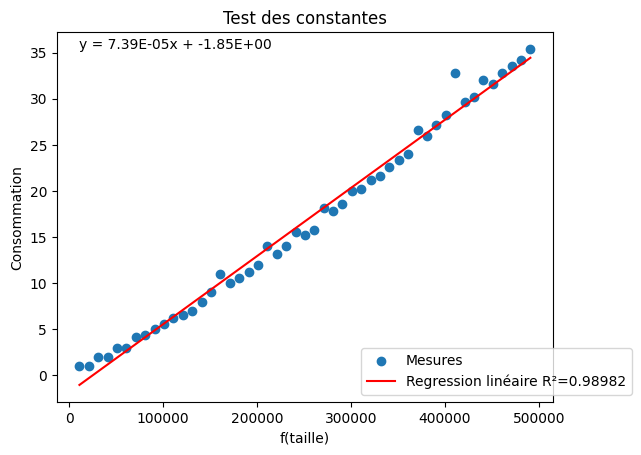

In [427]:
# TODO Test des constantes
measures_count_sort_dict: dict[int: int] = {}
for m in measures_count_sort:
    measures_count_sort_dict[m.size + m.max_number] = m.mean # f(x) = x + m pour count sort
test_de_rapport(measures_count_sort_dict, "f(taille)", "Consommation", "Test des constantes")

<u>**Question 4.b):**</u> Analysez le graphe obtenu pour le test des constantes.

Dans le graphique, nous pouvons voir que les données suivent assez près une tendance linéaire donnée par l'équation y = 7.39e-5 * x - 1.85 (y = c * f(x) + b). La consommation en temps de notre algorithme est donnée par y = c * f(x) où c = 7.39e-5 et f(x) = x + m. Cela correspond avec les valeurs obtenues lors du test du rapport.

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces algorithmes.

Lors de ce travail, nous avons pu démontrer la complexité temporelle de plusieurs algorithmes de façon pratique. Nous avons observé que chaque algorithme possède des forces et faiblesses qui le rendent plus ou moins adapté selon le contexte. L'analyse expérimentale nous a permis de comparer la performance théorique des algorithmes à leur performance en réalité et d'identifier les facteurs qui ont de l'influence sur celle-ci (taille des données, distribution, optimisations).

Pour des petites listes ou des données presque triées, l'insertion sort est préférable. Le quicksort nous permet de traiter des plus grands tableaux de façon performante. L'ajout d'une heuristique de sélection du pivot pour le quicksort permet de réduire la probabilité d'obtenir des partitions déséquilibrées, et donc d'obtenir une meilleure performance en pratique. Le seuil de récursivité est lui aussi un bon ajout à l'algorithme quicksort, puisqu'il permet de limiter les appels récursifs inefficaces. Finalement, le count sort, est très utile pour les cas où les valeurs à trier se situent dans un domaine limité. 

 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.